In [141]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import numpy as np
import torchdata.datapipes as dp
import boto3
import os
import skimage
import PIL.Image
import json
import fsspec
from src.globals import DATA_DIR, LABELS_TO_INDS
from pathlib import Path

In [133]:
def download_from_s3(bucket: str, remote_path: str, local_path: str, s3_client=None):
    if not s3_client:
        s3_client = boto3.client("s3")
    s3_client.download_file(bucket, remote_path, local_path)


def split_bucket_from_path(x: str):
    return "".join(x.split("/")[2:3]), "/".join(x.split("/")[3:])


def combine_bands(arrays: list[np.array], max_res=(120, 120)):
    """Combines bands into one array, upscaling each band to max_res.

    Args:
        arrays (list): list of bands
        max_res (tuple, optional): Max height & width to resize bands to. Defaults to (120, 120).

    Returns:
        np.array: Concatenated & resized bands.
    """
    result = np.zeros(shape=(*max_res, len(arrays)))
    for i, array in enumerate(arrays):
        assert array.shape[0] <= max_res[0]
        assert array.shape[1] <= max_res[1]
        result[:, :, i] = cv2.resize(array, dsize=max_res)
    return result


def get_first_n_pcs(img: np.array, num_components: int):
    """Perform PCA on a single image and return principle components which make up the most variance.

    Args:
        img (np.array): Original image of shape (h, w, num_bands).
        num_components (int): Desired number of components to be returned.

    Returns:
        np.array: Components with shape (h, w, num_components).
    """
    # Convert 2d bands into 1-d arrays
    bands_vectorized = np.zeros(shape=(img.shape[0] * img.shape[1], img.shape[2]))
    for i in range(img.shape[-1]):
        flattened_band = img[:, :, i].flatten()
        flattened_band_standard = (
            flattened_band - flattened_band.mean()
        ) / flattened_band.std()
        bands_vectorized[:, i] = flattened_band_standard

    cov = np.cov(bands_vectorized.transpose())
    eig_val, eig_vec = np.linalg.eig(cov)

    # Ordering Eigen values and vectors
    order = eig_val.argsort()[::-1]
    eig_val = eig_val[order]
    eig_vec = eig_vec[:, order]

    # Projecting data on Eigen vector directions resulting in Principal Components
    pcs = np.matmul(bands_vectorized, eig_vec)

    # Rearranging 1-d arrays to 2-d arrays of image size
    PC_2d = np.zeros((img.shape[0], img.shape[1], num_components))
    for i in range(num_components):
        PC_2d[:, :, i] = pcs[:, i].reshape(-1, img.shape[1])

    # normalizing between 0 to 255
    PC_2d_Norm = np.zeros((img.shape[0], img.shape[1], num_components))
    for i in range(num_components):
        PC_2d_Norm[:, :, i] = cv2.normalize(
            PC_2d[:, :, i], np.zeros(img.shape), 0, 255, cv2.NORM_MINMAX
        )

    return PC_2d_Norm[:, :, : num_components + 1]

In [3]:
# Download one folder to local
folder = "S2A_MSIL2A_20170613T101031_14_65/"
bucketname = f"s3://mi4people-soil-project/BigEarthNet-v1.0/{folder}"
pipe = dp.iter.IterableWrapper([bucketname])
pipe = pipe.list_files_by_fsspec()

tifs = [x for x in pipe if ".tif" in x]
for tif in tifs:
    bucket, remote = split_bucket_from_path(tif)
    file = tif.split("/")[-1]
    if not os.path.isdir(
        f"/home/philip/Projects/MI4People/MI4People_soil_quality/data/raw/bigearth_data/{folder}"
    ):
        os.mkdir(
            f"/home/philip/Projects/MI4People/MI4People_soil_quality/data/raw/bigearth_data/{folder}"
        )
    local = (
        f"/home/philip/Projects/MI4People/MI4People_soil_quality/data/raw/bigearth_data/{folder}"
        + file
    )
    download_from_s3(bucket=bucket, remote_path=remote, local_path=local)

In [5]:
tif_dir = f"/home/philip/Projects/MI4People/MI4People_soil_quality/data/raw/bigearth_data/{folder}"
local_tifs = [os.path.join(tif_dir, x) for x in os.listdir(tif_dir)]
imgs = [skimage.io.imread(path) for path in local_tifs]
bands = [tif.split("_")[-1].split(".")[0] for tif in local_tifs]
resized = combine_bands(imgs)

In [6]:
def get_s3_folder_content(bucket_path=f"s3://mi4people-soil-project/BigEarthNet-v1.0/"):
    """Gets all top level-elements in buckets path.

    Args:
        bucket_path (string, optional): Path in bucket to list elements from. Defaults to f"s3://mi4people-soil-project/BigEarthNet-v1.0/".

    Returns:
        list: list of full paths of all top-level-elements.
    """
    top_pipe = dp.iter.IterableWrapper([bucket_path])
    top_pipe = top_pipe.list_files_by_fsspec()
    folders = list(top_pipe)
    return folders

In [160]:
def is_tif_file(path):
    if path.endswith(".tif"):
        return True
    return False


def is_json_file(path):
    if path.endswith(".json"):
        return True
    return False


def group_key_by_folder(path_and_stream):
    return "".join(path_and_stream[0].split("/")[-1].split("_")[:5])


def chunk_to_dataloader_dict(chunk):
    json_files = [path for path in chunk if is_json_file(path)]
    assert len(json_files) == 1, "Only one label json per image is permitted."
    image_files = [path for path in chunk if is_tif_file(path)]
    return {"label": json_files[0], "data": image_files}


def read_json_from_path(path):
    json_content = json.loads(fsspec.open(path, mode="r").open().read())
    return json_content


def read_imgs_from_paths(path_list):
    image_contents = [
        np.array(PIL.Image.open(fsspec.open(path, mode="rb").open()))
        for path in path_list
    ]
    return image_contents


def get_labels(meta_dict):
    return meta_dict["labels"]


def get_label_inds(label_list):
    return [LABELS_TO_INDS[label] for label in label_list]


def pca_on_label_and_data(combined_image):
    return get_first_n_pcs(combined_image, num_components=3)

In [161]:
def get_bigearth_pca_pipe(folders):
    """Given a list of paths (in a bucket), returns a datapipe with simple 3-component PCA performed on images.
        May be passed in the contruction of a dataloader in  the dataset argument.

    Args:
        folders (list): List of folders to process. Each fodler must contain 12 tifs, one for each band and one json with metadata.

    Returns:
        torch.utils.data.datapipes.iter.callable.MapperIterDataPipe: Iterable datapipe yielding dicts with keys "data" and "label".
            Data is a single numpy array of the 3 first PCs of all bands, label a list of integers from /data/raw/bigearth_labels.json.
    """
    img_pipe = dp.iter.IterableWrapper(folders)
    img_pipe = img_pipe.list_files_by_fsspec()
    img_pipe = img_pipe.groupby(group_key_fn=group_key_by_folder, group_size=13)
    img_pipe = img_pipe.map(chunk_to_dataloader_dict)
    img_pipe = img_pipe.map(read_json_from_path, input_col="label")
    img_pipe = img_pipe.map(get_labels, input_col="label")
    img_pipe = img_pipe.map(get_label_inds, input_col="label")
    img_pipe = img_pipe.map(read_imgs_from_paths, input_col="data")
    img_pipe = img_pipe.map(combine_bands, input_col="data")
    img_pipe = img_pipe.map(pca_on_label_and_data, input_col="data")
    return img_pipe


list(get_bigearth_pca_pipe(top_list[:5]))

[{'label': [6],
  'data': array([[[188.09483601, 176.40315967, 222.95876364],
          [175.58970741, 184.6244173 , 242.20962361],
          [184.60862153, 135.91949296, 239.8141459 ],
          ...,
          [153.64484708, 139.60481494, 124.96075169],
          [174.59686174, 109.48582147, 122.78130287],
          [181.6045172 , 103.72928383, 126.2674528 ]],
  
         [[186.75977049, 188.11358058, 223.83162389],
          [199.5205919 , 140.69982842, 226.72836445],
          [193.7657399 , 128.64974757, 233.39513867],
          ...,
          [147.35468365, 132.82923025, 145.07847335],
          [152.2390287 , 137.68121512, 137.46985989],
          [164.42866103, 123.66828211, 127.76627879]],
  
         [[201.72814428, 171.83991737, 221.97931779],
          [209.92593122, 141.36922012, 218.84387942],
          [193.71295401, 153.31207056, 226.91936194],
          ...,
          [153.2198788 ,  99.65712445, 153.14183484],
          [136.65125921, 139.28147064, 143.98813777],
     

In [59]:
img_pipe = dp.iter.IterableWrapper(
    [f"s3://mi4people-soil-project/BigEarthNet-v1.0/{folder}"]
)
img_pipe = img_pipe.list_files_by_fsspec()
img_pipe = img_pipe.filter(filter_fn=lambda x: x.endswith(".tif"))
img_pipe = img_pipe.open_files_by_fsspec(mode="rb")
img_pipe = img_pipe.map(lambda x: (x[0], PIL.Image.open(x[1])))

gt_pipe = dp.iter.IterableWrapper(
    [f"s3://mi4people-soil-project/BigEarthNet-v1.0/{folder}"]
)
gt_pipe = gt_pipe.list_files_by_fsspec()
gt_pipe = gt_pipe.filter(filter_fn=lambda x: x.endswith(".json"))
gt_pipe = gt_pipe.open_files_by_fsspec()
# gt_pipe = gt_pipe.parse_json_files()
# gt_pipe = gt_pipe.map(lambda x: json.loads(x[1].read())["labels"])


gt_list = [x for x in gt_pipe]
gt_list = list(gt_pipe)
print(gt_list)
img_list = [x for x in img_pipe]

[('s3://mi4people-soil-project/BigEarthNet-v1.0/S2A_MSIL2A_20170613T101031_14_65/S2A_MSIL2A_20170613T101031_14_65_labels_metadata.json', StreamWrapper<<_io.TextIOWrapper encoding='UTF-8'>>)]


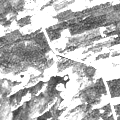

In [85]:
np.array(img_list[1]).shape
img_list[1].show()

In [28]:
get_first_n_pcs(resized, 3).shape

(120, 120, 3)